In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from trainer import Trainer, generate_data_iter
import utils
import cam

import os

### Metrics

In [ ]:
settings = [
    'resnet18-CIFAR10', 'resnet18-FashionMNIST', 
    'resnet18-Imagenette', 'densenet121-Imagenette'
]
for setting in settings:
    dataset = setting[setting.find('-')+1:]
    mean_df = sum([pd.read_csv(
        f'./thesis/cam/cam_metrics/{dataset}/CAM-{setting}-seed{i}.csv', index_col= 0
    ) for i in range(3)]) /3
    mean_df.to_csv(f'./thesis/paper_tables/CAM-{setting}.csv')
    mean_df.to_excel(f'./thesis/paper_tables/CAM-{setting}.xlsx')

### Casual Metric


In [ ]:
def plot_single_casual_metric(
    model_mode: str,
    dataset: str,
    ins: bool = True,
    loc: str = 'lower right',
    *args
):
    cam_names = [
        'CAM', 'GradCAM', 'GradCAMpp', 'SMGradCAMpp', 'LayerCAM', 'XGradCAM', 'ScoreCAM',  'SSCAM', 'ISCAM'
    ]

    ins_mode = 'Ins' if ins else 'Del'
    for i in range(len(cam_names)):
        score = sum([
            np.load(f'./thesis/cam/cam_casual_metrics/{dataset}/{ins_mode}-{cam_names[i]}-{dataset}-{str.lower(model_mode)}-seed{j}.npy')
            for j in range(3)
        ]) / 3
        x_axis = np.linspace(0, 1, len(score))
        plt.plot(x_axis, score, label = cam_names[i], lw = 2.2)
        plt.xlim([0.0, 1.00])
        plt.ylim([0.0, 1.01])
        title = 'Insertion' if ins else 'Deletion'
        plt.title(f'{title} Curve\n{dataset}({model_mode})', fontsize = 20)
        plt.tick_params(axis = 'both', labelsize = 15)
        plt.xlabel('Pixels Inserted', fontsize = 18)
        plt.ylabel('Prediction', fontsize = 18)
    plt.legend(loc = loc)

single_size = 6
settings = [
    ['ResNet18',        'FashionMNIST',         True,       'lower right'],
    ['ResNet18',        'CIFAR10',              True,       'lower right'],
    ['ResNet18',        'Imagenette',           True,       'lower right'],
    ['DenseNet121',     'Imagenette',           True,       'lower right'],
    ['ResNet18',        'FashionMNIST',         False,      'upper right'],
    ['ResNet18',        'CIFAR10',              False,      'upper right'],
    ['ResNet18',        'Imagenette',           False,      'upper right'],
    ['DenseNet121',     'Imagenette',           False,      'upper right'],
]

fig = plt.figure(figsize=(4*single_size, 2*single_size))
for i in range(len(settings)):
    plt.subplot(2, 4, i+1)
    plot_single_casual_metric(*settings[i])
    plt.tight_layout()
plt.savefig('./thesis/pics/paper_cam_casual.png', bbox_inches = 'tight', pad_inches = 0.03)
plt.savefig('./thesis/pics/paper_cam_casual.svg', bbox_inches = 'tight', pad_inches = 0.03)

### Plot

In [ ]:
def draw_cam_pic(seed, single_size = 3):
    def get_raw_pics(model_mode, dataset, idx, *args):
        utils.set_random_seed(seed)
        if dataset != 'Imagenette': 
            data_iter = generate_data_iter(dataset, 100, 'test')
        else:
            trainer = Trainer(
                model_mode, dataset, bs = 128, lr = 0.01, seed = seed, cuda = 0,
                use_lr_sche = True, use_wandb = False,
            )
            data_iter = generate_data_iter(dataset, 100, 'test')
        raw_imgs, _ = next(iter(data_iter))
        raw_imgs = np.transpose(raw_imgs.numpy(), (0, 2, 3, 1))
        return raw_imgs[idx]
    
    def get_cam_pics(cam_name, model_mode, dataset, idx, *args):
        cam_imgs = np.load(
            f'./thesis/cam/cam_pics/{dataset}/{cam_name}-{dataset}-{model_mode}-seed{seed}.npy'
        )
        return cam_imgs[idx]
    
    settings = [
        ['resnet18',        'FashionMNIST',         10],
        ['resnet18',        'FashionMNIST',         11],
        ['resnet18',        'CIFAR10',              10],
        ['resnet18',        'CIFAR10',              11],
        ['resnet18',        'Imagenette',           10],
        ['resnet18',        'Imagenette',           11],
        ['densenet121',     'Imagenette',           10],
        ['densenet121',     'Imagenette',           11],
    ]
    
    titles = [
        'FashionMNIST-1\n(ResNet)',  'FashionMNIST-2\n(ResNet)', 
        'CIFAR10-1\n(ResNet)',        'CIFAR10-2\n(ResNet)', 
        'Imagenette-1\n(ResNet)',     'Imagenette-2\n(ResNet)',
        'Imagenette-1\n(DenseNet)',    'Imagenette-2\n(DenseNet)'
    ]
    
    cam_names = [
        'CAM', 'GradCAM', 'GradCAMpp', 'SMGradCAMpp', 'LayerCAM', 'XGradCAM', 'ScoreCAM',  'SSCAM', 'ISCAM'
    ]
    
    fontsize = 30
    plt.tight_layout()
    rows = len(cam_names) + 1
    fig = plt.figure(figsize = (len(settings) * single_size +3, rows * single_size + 3))
    
    for row in range(rows):
        if row == 0:
            raw_imgs = [get_raw_pics(*settings[i]) for i in range(len(settings))]
            for i in range(len(settings)):
                plt.subplot(rows, len(settings), i + 1 + row * len(settings))
                plt.imshow(raw_imgs[i])
                plt.xticks([])
                plt.yticks([])
                plt.title(titles[i], fontsize = fontsize)
                if i == 0:
                    plt.ylabel('Raw Image', fontsize = fontsize)
        
        else:
            cam_imgs = [get_cam_pics(cam_names[row - 1], *settings[i]) for i in range(len(settings))]
            for i in range(len(settings)):
                plt.subplot(rows, len(settings), i + 1 + row * len(settings))
                plt.imshow(cam_imgs[i])
                plt.xticks([])
                plt.yticks([])
                if i == 0:
                    plt.ylabel(cam_names[row - 1], fontsize = fontsize)
    plt.savefig('./thesis/pics/paper_cam.png', bbox_inches = 'tight', pad_inches = 0.03)
    plt.savefig('./thesis/pics/paper_cam.svg', bbox_inches = 'tight', pad_inches = 0.03)
    
draw_cam_pic(0, single_size = 5)

100 95 95


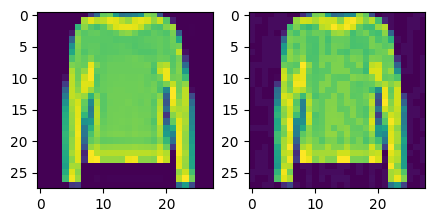

In [12]:
def load_raw_pics(attack_name, model_mode, dataset, seed = 0, idx = 0):
    seed = 2
    utils.set_random_seed(seed)
    if dataset == 'Imagenette':
        trainer = Trainer(
            model_mode = model_mode,
            dataset = dataset,
            bs = 128,
            lr = 0.01,
            seed = seed,
            cuda = 3,
            use_lr_sche = True,
            use_wandb = False,
        )
    
    data_iter = generate_data_iter(dataset, 100, 'test')
    raw_imgs, labels = next(iter(data_iter))
    
    suc_indices = np.load(f'./thesis/attack/indices/{dataset}/suc-{dataset}-{model_mode}-seed0.npy')
    att_indices = np.load(f'./thesis/attack/indices/{dataset}/{attack_name}-{dataset}-{model_mode}-seed{seed}.npy')
    print(len(suc_indices), sum(suc_indices), len(att_indices))
    raw_imgs = np.transpose(raw_imgs.numpy(), (0, 2, 3, 1))[suc_indices][att_indices]
    return raw_imgs[idx]

def load_att_pics(attack_name, model_mode, dataset, seed = 0, idx = 0): 
    seed = 2   
    att_imgs = np.load(f'./thesis/attack/attack_pics/{dataset}/{attack_name}-{dataset}-{model_mode}-seed{seed}.npy')
    att_indices = np.load(f'./thesis/attack/indices/{dataset}/{attack_name}-{dataset}-{model_mode}-seed{seed}.npy')
    att_imgs = np.transpose(att_imgs, (0, 2, 3, 1))[att_indices]
    return att_imgs[idx]

att_name, model_mode, dataset, seed, idx = 'FGSM', 'resnet18', 'FashionMNIST', 1, -1
args = [att_name, model_mode, dataset, seed, idx]
plt.subplot(1, 2, 1)
plt.imshow(load_raw_pics(*args)), 
plt.subplot(1, 2, 2)
plt.imshow(load_att_pics(*args))
# load_raw_pics('FGSM', 'resnet18', 'FashionMNIST', 1, idx)

In [5]:
def draw_attack_pic(attack_name, seed = 2):
    trainer_settings = [
        ['FashionMNIST',    'ResNet18'],
        ['CIFAR10',         'ResNet18'],
        ['Imagenette',      'ResNet18'],
        # ['Imagenette',      'DenseNet121'],
    ]
    for trainer_setting in trainer_settings:
        model_mode, dataset = str.lower(trainer_setting[1]), trainer_setting[0],
        utils.set_random_seed(seed)
        trainer = Trainer(
            model_mode, dataset,
            bs = 128, lr = 0.01, seed = seed, cuda = 0,
            use_lr_sche = True,
            use_wandb = False,
        )
        
        data_iter = generate_data_iter(dataset, 100, 'test')
        raw_imgs, labels = next(iter(data_iter))
        
        suc_indices = np.load(f'./thesis/attack/indices/{dataset}/suc-{dataset}-{model_mode}.npy')
        att_indices = np.load(f'./thesis/attack/indices/{dataset}/{attack_name}-{dataset}-{model_mode}.npy')
        att_imgs = np.load(f'./thesis/attack/attack_pics{dataset}/{attack_name}-{dataset}-{model_mode}-seed{seed}.npy')
        print(len(raw_imgs[suc_indices]))
        print(len(att_indices))
draw_attack_pic('IFGSM')

95
95
95
95
99
99
97
99
